# Setup Code

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# imports
import torch
import torch.nn.functional as F
import numpy as np
import sys
import os
from matplotlib import pyplot as plt

In [3]:
# select devices
if torch.cuda.is_available():
    print("Good to go!")
    DEVICE = torch.device("cuda")
else:
    print("Bad to go!")
    DEVICE = torch.device("cpu")

Good to go!


Load config from config files.

In [4]:
# load config
sys.path.append(os.getcwd())
# choose between ship, lego
import configs.ship, configs.lego
sample_t: tuple = (2,6)
scale_factor = 3
# change config file here
config = configs.lego

Load the dataset and show the first one.

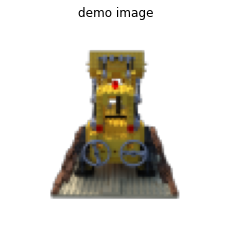

and its pose: 
[[-9.99902189e-01  4.19224519e-03 -1.33457193e-02 -5.37983216e-02]
 [-1.39886811e-02 -2.99659073e-01  9.53943670e-01  3.84547043e+00]
 [-4.65661287e-10  9.54037189e-01  2.99688309e-01  1.20808232e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


In [5]:
from nerf.data import load_blender
imgs, poses, int_mat = load_blender(config.datadir, device=DEVICE, scale_factor=scale_factor)
img_n, img_h, img_w = imgs.shape[:3]
# visualize
plt.imshow(np.array(imgs[0].to(device="cpu")))
plt.axis("off")
plt.title("demo image")
plt.show()
print("and its pose: ")
print(np.array(poses[0].to(device="cpu")))

# Test Functions

In [6]:
# compute rays
from nerf.graphics import compute_rays

rays_o, rays_d = compute_rays((img_h, img_w), int_mat, poses[0])
print("origin: ", rays_o[0,0])
print("normalized origin: ", F.normalize(rays_o[0,0], dim=0))
print("center of ray: ", rays_d[img_h//2,img_w//2])

origin:  tensor([-0.0538,  3.8455,  1.2081], device='cuda:0', dtype=torch.float64)
normalized origin:  tensor([-0.0133,  0.9539,  0.2997], device='cuda:0', dtype=torch.float64)
center of ray:  tensor([ 4.6566e-10, -9.5404e-01, -2.9969e-01], device='cuda:0',
       dtype=torch.float64)


In [7]:
# query from rays
from nerf.graphics import queries_from_rays
samples = None
samples, depths = queries_from_rays(rays_o, rays_d, sample_t, 8)
print("samples[0, 0]: ", samples[0,0])
print("depths: ", depths)

samples[0, 0]:  tensor([[ 1.2409, -0.0335,  1.3851],
        [ 1.6337, -1.2105,  1.4388],
        [ 1.9701, -2.2184,  1.4848],
        [ 2.3239, -3.2786,  1.5332],
        [ 2.6655, -4.3019,  1.5799],
        [ 3.0647, -5.4980,  1.6345],
        [ 3.4456, -6.6392,  1.6866],
        [ 3.8184, -7.7561,  1.7376]], device='cuda:0', dtype=torch.float64)
depths:  tensor([ 4.0932,  5.3351,  6.3987,  7.5174,  8.5972,  9.8594, 11.0636, 12.2422],
       device='cuda:0')


In [8]:
# test posencode

from nerf.nerf_helper import PosEncode

L = 2
x = torch.tensor([[1.1, 1.2, 1.3], [2.1, 2.2, 2.3]])
enc_x = PosEncode(x, L, True)

print(enc_x)




tensor([[1.1000, 0.0000, 1.0000, 0.5038, 0.8638, 1.2000, 0.0000, 1.0000, 0.5447,
         0.8386, 1.3000, 0.0000, 1.0000, 0.5843, 0.8115],
        [2.1000, 0.0000, 1.0000, 0.5233, 0.8521, 2.2000, 0.0000, 1.0000, 0.5455,
         0.8381, 2.3000, 0.0000, 1.0000, 0.5673, 0.8235]])


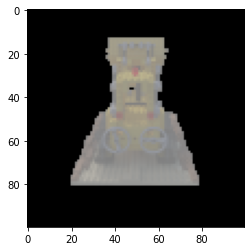

In [9]:
# test render from nerf
from nerf.graphics import render_from_nerf
fake_depth = torch.Tensor([1])
fake_nerf_output = imgs[0].cpu().reshape(img_h, img_w, 1, 4)
rgb, depth = render_from_nerf(fake_nerf_output, fake_depth)
plt.imshow(rgb)
plt.show()

# Train

In [10]:
# One iteration of TinyNeRF (forward pass).
# TODO train
# raise Exception("nothing wrong")

No checkpoint found
torch.Size([100, 100, 4, 4])
train_it: 0 img_idx:  4 loss: 6409.316030277657
pred[50,50]: tensor([0.5024, 0.5276, 0.5337], device='cuda:0', grad_fn=<SelectBackward0>)
torch.Size([100, 100, 4, 4])
Iteration  0
Val loss:  tensor(0.0317, device='cuda:0', grad_fn=<MseLossBackward0>)


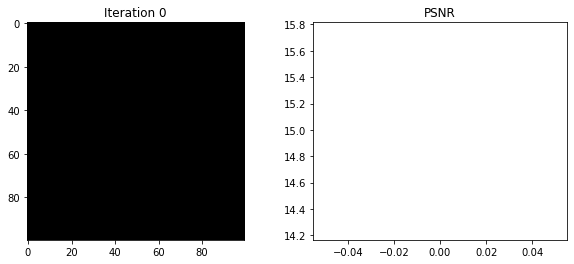

torch.Size([100, 100, 4, 4])
train_it: 1 img_idx:  0 loss: 950.6315263360246
pred[50,50]: tensor([0., 0., 0.], device='cuda:0', grad_fn=<SelectBackward0>)
torch.Size([100, 100, 4, 4])
train_it: 2 img_idx:  3 loss: 3614.486612841215
pred[50,50]: tensor([0., 0., 0.], device='cuda:0', grad_fn=<SelectBackward0>)
torch.Size([100, 100, 4, 4])
train_it: 3 img_idx:  2 loss: 1754.9695040369088
pred[50,50]: tensor([0., 0., 0.], device='cuda:0', grad_fn=<SelectBackward0>)
torch.Size([100, 100, 4, 4])
train_it: 4 img_idx:  1 loss: 1003.2455517108804
pred[50,50]: tensor([0., 0., 0.], device='cuda:0', grad_fn=<SelectBackward0>)
torch.Size([100, 100, 4, 4])
train_it: 5 img_idx:  0 loss: 950.6315263360246
pred[50,50]: tensor([0., 0., 0.], device='cuda:0', grad_fn=<SelectBackward0>)
torch.Size([100, 100, 4, 4])
train_it: 6 img_idx:  1 loss: 1003.2455517108804
pred[50,50]: tensor([0., 0., 0.], device='cuda:0', grad_fn=<SelectBackward0>)
torch.Size([100, 100, 4, 4])
train_it: 7 img_idx:  3 loss: 3614.486

KeyboardInterrupt: 

In [13]:
from nerf.model import NeRF, TinyNeRF
from nerf.nerf_helper import nerf_iter_once, tinynerf_iter_once
import os.path

# parameters
L_pos = 10
L_dir = 4
depth_samples_per_ray = 32

chunksize = 8192
lr = 5e-3
betas=(0.9, 0.999)
num_it = 2000
display_every = 10

# load validation data
# imgs_val, poses_val, int_mat_val = load_blender(config.datadir, data_type="val",scale_factor=2, device=DEVICE)
# num_val = imgs_val.shape[0]

# models
# model = NeRF(ch_in_pos=6*L_pos, ch_in_dir=6*L_dir, fc_width=64, fc_depth=4, skips=[2])
model = TinyNeRF(6*L_pos+3, fc_width=128)
model.to(DEVICE)
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=lr,
    # betas=betas,
)
# optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)
seed = 9458
torch.manual_seed(seed)
np.random.seed(seed)
ckpt_path = 'nerf.pt'

# train
psnrs = []
its = []
i = 0
# check saved checkpoints
# if os.path.exists(ckpt_path):
if False:
    print("checkpoint found! Loading...")
    checkpoint = torch.load(ckpt_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    i = checkpoint['epoch']
    loss = checkpoint['loss']
    psnrs = checkpoint['prnrs']
    print("checkpoint loaded, i =",i)
else:
    print("No checkpoint found")

for i in range(i, num_it):
    gt_img_idx = np.random.randint(5)
    gt_img = imgs[gt_img_idx].to(DEVICE)
    gt_c2w = poses[gt_img_idx]

    pred_rgb,_ = tinynerf_iter_once(
                model,
                (img_h, img_w),
                int_mat,
                gt_c2w,
                sample_t,
                num_samples=4
                )
    optimizer.zero_grad()
    loss = torch.nn.functional.mse_loss(pred_rgb, gt_img[...,:3], reduction='sum')

    # plt.imshow(pred_rgb.detach().cpu().numpy())
    # plt.show()
    # plt.imshow(gt_img[...,:3].detach().cpu().numpy())
    # plt.show()
    print("train_it:", i, "img_idx: ", gt_img_idx, "loss:",float(loss))
    print("pred[50,50]:",pred_rgb[50,50])
    loss.backward()
    optimizer.step()

    if i % display_every == 0:
        val_idx = 0
        val_img = imgs[val_idx].to(DEVICE)
        val_c2w = poses[val_idx]
        # val_idx = np.random.randint(num_val)
        # val_img = imgs_val[val_idx].to(DEVICE)
        # val_c2w = poses_val[val_idx]

        pred_rgb,_ = tinynerf_iter_once(
                model,
                (img_h, img_w),
                int_mat,
                val_c2w,
                sample_t,
                num_samples=4
                )

        loss = torch.nn.functional.mse_loss(pred_rgb, val_img[...,:3])
        print("Iteration ", i)
        print("Val loss: ", loss)

        psnr = -10. * torch.log10(loss)
        psnrs.append(psnr.item())
        its.append(i)

        plt.figure(figsize=(10, 4))
        plt.subplot(121)
        img_np = pred_rgb.detach().cpu().numpy()
        plt.imshow(img_np)
        plt.title(f"Iteration {i}")
        plt.subplot(122)
        plt.plot(its, psnrs)
        plt.title("PSNR")
        plt.show()

        torch.save({
            'epoch': i,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            'psnr': psnrs
            }, ckpt_path)